In [ ]:
!pip install chess pgnparser numpy tensorflow keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147776 sha256=4a02329d0bf02e83b328c22f05be6777b2a2b818204f1a7d3c453281682551e1
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
  Created wheel for pgnparser: filename=pgnparser-1.0-py3-none-any.whl size=3868 sha256=e47b30e47403f0252b27b31e47ff026639817fda8dc4ae8fa3f055a50ac43f04
  Stored in directory: /root/.cache/pip/wheels/9c/6f/e3/3a8aa4a1180733a3e5c4dacfc7271643fb109611ee866a9f89
Successfully built chess pgnparser


In [ ]:
import chess
import chess.pgn
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
!wget https://database.lichess.org/standard/lichess_db_standard_rated_2024-01.pgn.zst


--2025-03-06 05:28:55--  https://database.lichess.org/standard/lichess_db_standard_rated_2024-01.pgn.zst
Resolving database.lichess.org (database.lichess.org)... 141.95.66.62, 2001:41d0:700:5e3e::
Connecting to database.lichess.org (database.lichess.org)|141.95.66.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32379325271 (30G) [application/octet-stream]
Saving to: ‘lichess_db_standard_rated_2024-01.pgn.zst’

lichess_db_standard 100%[===================>]  30.16G  29.7MB/s    in 18m 52s 

2025-03-06 05:47:47 (27.3 MB/s) - ‘lichess_db_standard_rated_2024-01.pgn.zst’ saved [32379325271/32379325271]



In [ ]:
!apt-get install zstd


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  zstd
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 603 kB of archives.
After this operation, 1,695 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 zstd amd64 1.4.8+dfsg-3build1 [603 kB]
Fetched 603 kB in 0s (2,018 kB/s)
Selecting previously unselected package zstd.
(Reading database ... 124947 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.8+dfsg-3build1_amd64.deb ...
Unpacking zstd (1.4.8+dfsg-3build1) ...
Setting up zstd (1.4.8+dfsg-3build1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!unzstd --stdout lichess_db_standard_rated_2024-01.pgn.zst | head -n 50000 > small_games.pgn


In [ ]:
!ls -lh small_games.pgn


-rw-r--r-- 1 root root 5.6M Mar  6 05:48 small_games.pgn


In [ ]:
!head -n 20 small_games.pgn


[Event "Rated Blitz game"]
[Site "https://lichess.org/iSjpt213"]
[Date "2024.01.01"]
[Round "-"]
[White "Detectie"]
[Black "youssefaymn"]
[Result "1-0"]
[UTCDate "2024.01.01"]
[UTCTime "00:00:14"]
[WhiteElo "1176"]
[BlackElo "1155"]
[WhiteRatingDiff "+5"]
[BlackRatingDiff "-6"]
[ECO "C50"]
[Opening "Italian Game: Anti-Fried Liver Defense"]
[TimeControl "300+3"]
[Termination "Normal"]

1. e4 { [%eval 0.2] [%clk 0:05:00] } 1... e5 { [%eval 0.17] [%clk 0:05:00] } 2. Nf3 { [%eval 0.29] [%clk 0:05:02] } 2... Nc6 { [%eval 0.32] [%clk 0:05:02] } 3. Bc4 { [%eval 0.21] [%clk 0:05:04] } 3... h6?! { [%eval 0.76] [%clk 0:05:03] } 4. O-O { [%eval 0.56] [%clk 0:05:02] } 4... Nf6 { [%eval 0.75] [%clk 0:05:04] } 5. d3?! { [%eval 0.13] [%clk 0:05:00] } 5... d6 { [%eval 0.43] [%clk 0:05:05] } 6. Be3 { [%eval 0.13] [%clk 0:04:55] } 6... Be6?! { [%eval 0.7] [%clk 0:05:05] } 7. Bxe6 { [%eval 0.5] [%clk 0:04:56] } 7... fxe6 { [%eval 0.42] [%clk 0:05:08] } 8. Nbd2 { [%eval 0.33] [%clk 0:04:57] } 8... d5 { [%

In [ ]:
#parsing the game from the pgn file
def parse_pgn(pgn_file, num_games=2000):
    games = []
    with open(pgn_file) as f:
      #loop through the games
        for _ in range(num_games):
            game = chess.pgn.read_game(f)
            if game is None:
                break
            games.append(game)
    return games
#load the gmaes
games = parse_pgn("small_games.pgn", num_games=2000)
print(f"Loaded {len(games)} games successfully.")

Loaded 2000 games successfully.


In [ ]:
#
def board_to_array(board):
  #piece_map maps chess pieces to numbers
    piece_map = {
        'p': -1, 'n': -2, 'b': -3, 'r': -4, 'q': -5, 'k': -6,
        'P': 1, 'N': 2, 'B': 3, 'R': 4, 'Q': 5, 'K': 6, '.': 0
    }
    #converts board to a string
    board_str = str(board).replace("\n", " ").split()
    #creates an array
    #reshapes to a 8x8 grid to represent a chess board
    return np.array([piece_map[piece] for piece in board_str]).reshape(8, 8)

def extract_features_and_labels(games, max_moves=50):
  #X stores board states
  #Y stores game results
    X, y = [], []
    for game in games:
        board = game.board()
        result = game.headers["Result"]

        # One-hot encoding: [White win, Black win, Draw]
        if result == "1-0":
           # White wins
            label = [1, 0, 0]
        elif result == "0-1":
           # Black wins
            label = [0, 1, 0]
        else:
          # Draw
            label = [0, 0, 1]

        move_count = 0
        for move in game.mainline_moves():
          #applies the move to the board
            board.push(move)
          #current board state turns into an array
          #add board state to X
            X.append(board_to_array(board))
          #store the result to Y
            y.append(label)
            move_count += 1
            #stops when max moves of 50 is reachesd
            if move_count >= max_moves:
                break
    #return array of board state and results
    return np.array(X), np.array(y)

X, y = extract_features_and_labels(games)
 # Reshape for CNN input
X = X.reshape(X.shape[0], 8, 8, 1)
print(f"Dataset Shape: X={X.shape}, y={y.shape}")


Dataset Shape: X=(90554, 8, 8, 1), y=(90554, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


In [ ]:
model = Sequential([
    #first layer: 64 filters
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(8, 8, 1)),
    #normalizes activation
    BatchNormalization(),
    #extracts dominant features
    MaxPooling2D(pool_size=(2, 2)),

    #second layer: 128 filters
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    #normalizes activation
    BatchNormalization(),
    #extracts dominant features
    MaxPooling2D(pool_size=(2, 2)),

    #third layer: 256 filter
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    #normalizes activation
    BatchNormalization(),

    Flatten(),
    #relu introduces non-linearity
    Dense(512, activation='relu'),
    Dropout(0.3),
    #relu introduces non-linearity
    Dense(256, activation='relu'),
    Dropout(0.3),
    #softmax turns the final layer into proability; white, black, and draw sum up to 1
    Dense(3, activation='softmax')  # Output: [White Win, Black Win, Draw]
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 8, 8, 64)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,028,355 (3.92 MB)

 Trainable params: 1,027,459 (3.92 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
#training through epochs with batch size 32
model.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 79s 34ms/step - accuracy: 0.4922 - loss: 0.8877 - val_accuracy: 0.5249 - val_loss: 0.7975
Epoch 2/5
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 78s 32ms/step - accuracy: 0.5334 - loss: 0.8174 - val_accuracy: 0.4950 - val_loss: 0.8138
Epoch 3/5
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 75s 33ms/step - accuracy: 0.5837 - loss: 0.7625 - val_accuracy: 0.4799 - val_loss: 0.8714
Epoch 4/5
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.6421 - loss: 0.6854 - val_accuracy: 0.5070 - val_loss: 0.9532
Epoch 5/5
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.6826 - loss: 0.6195 - val_accuracy: 0.4978 - val_loss: 0.9841


In [ ]:
#estimating model accuracy
loss, accuracy = model.evaluate(X, y)
print(f"Model Accuracy: {accuracy:.2f}")

2830/2830 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7073 - loss: 0.5657
Model Accuracy: 0.67


In [ ]:
#plays a random game
import random
board = games[random.randint(0, len(games)-1)].board()
sample_input = board_to_array(board).reshape(1, 8, 8, 1)
prediction =  model.predict(sample_input)

print(f"Predicted Outcome: White Win: {prediction[0][0]:.2f}, Black Win: {prediction[0][1]:.2f}, Draw: {prediction[0][2]:.2f}")
print("Board Position:")
print(board)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Predicted Outcome: White Win: 0.45, Black Win: 0.48, Draw: 0.07
Board Position:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [ ]:
history = model.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 75s 33ms/step - accuracy: 0.7172 - loss: 0.5558 - val_accuracy: 0.5157 - val_loss: 1.2014
Epoch 2/5
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.7423 - loss: 0.5166 - val_accuracy: 0.5174 - val_loss: 1.1546
Epoch 3/5
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.7663 - loss: 0.4723 - val_accuracy: 0.5021 - val_loss: 1.4433
Epoch 4/5
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.7807 - loss: 0.4374 - val_accuracy: 0.5069 - val_loss: 1.2177
Epoch 5/5
2264/2264 ━━━━━━━━━━━━━━━━━━━━ 85s 35ms/step - accuracy: 0.7931 - loss: 0.4139 - val_accuracy: 0.5062 - val_loss: 1.4607


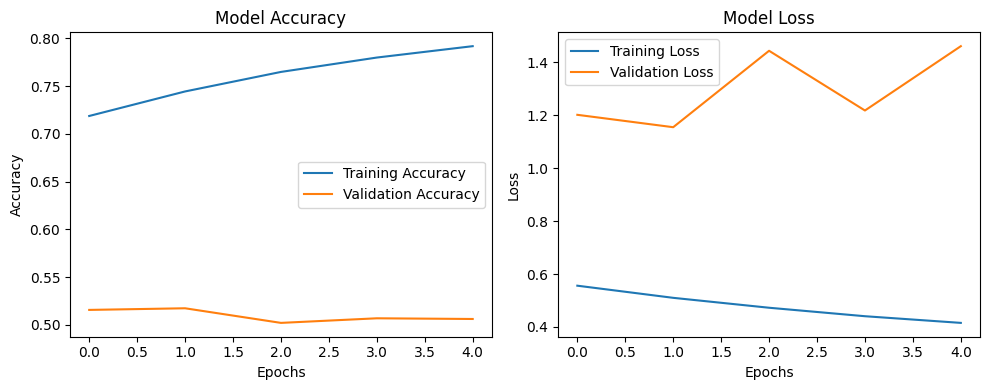

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.show()

2830/2830 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step


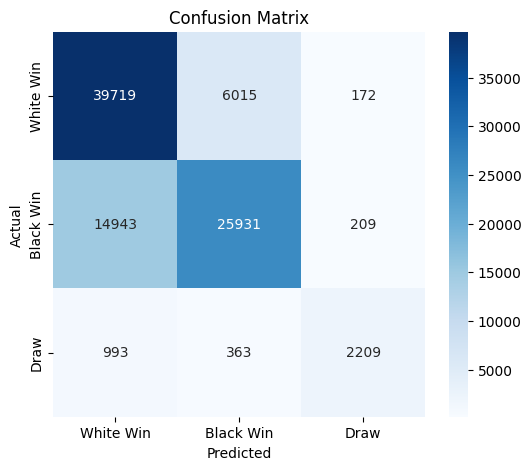

Classification Report:
              precision    recall  f1-score   support

   White Win       0.71      0.87      0.78     45906
   Black Win       0.80      0.63      0.71     41083
        Draw       0.85      0.62      0.72      3565

    accuracy                           0.75     90554
   macro avg       0.79      0.71      0.74     90554
weighted avg       0.76      0.75      0.75     90554



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Predict on the dataset
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
class_labels = ["White Win", "Black Win", "Draw"]

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_labels))
